In [345]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from sympy import * 

In [346]:
Ainit = 1e-5
kon = 1e5
k = Ainit*kon
koff = 1e-4
qon = 6.5e3
q = qon*Ainit
qoff = 4.7e-3

delta2 = 10
delta4 = 10
delta7 = 10
delta5 = delta4*delta7/delta2
delta6 = delta4
k1 = 2*k
k1off = koff
k2 = delta2*k
k2off = 2*koff
k3 = q
k3off = qoff
k4 = delta4*q
k4off = qoff
k5 = delta5*q
k5off = qoff
k6 = 2*delta6*k
k6off = koff
k7 = delta7*k
k7off = 2*koff

alpha1 = k1/k1off
alpha2 = k2/k1off
gamma2 = k2off/k1off
alpha3 = k3/k1off
gamma3 = k3off/k1off
alpha4 = k4/k1off
gamma4 = k4off/k1off
alpha5 = k5/k1off
gamma5 = k5off/k1off
alpha6 = k6/k1off
gamma6 = k6off/k1off
alpha7 = k7/k1off
gamma7 = k7off/k1off

beta_t = 10
phi = 2
beta_f = beta_t*phi

In [347]:
def model(t, z):

    dA10 = alpha1*(beta_t- z[0] - z[1] - z[2] - z[3] - z[4])*(1 - (z[0] + z[3] + 2*(z[1] + z[4]))) - z[0] - alpha2*z[0]*(1 - (z[0] + z[3] + 2*(z[1] + z[4]))) + gamma2*z[1] - alpha4*z[0]*(1 - beta_f*(z[2] + z[3] + z[4])) + gamma4*z[3]
    dA20 = alpha2*z[0]*(1 - (z[0] + z[3] + 2*(z[1] + z[4]))) - gamma2*z[1] - alpha5*z[1]*(1 - beta_f*(z[2] + z[3] + z[4])) + gamma5*z[4]
    dA01 = alpha3*(beta_t- z[0] - z[1] - z[2] - z[3] - z[4])*(1 - beta_f*(z[2] + z[3] + z[4])) - gamma3*z[2] - alpha6*z[2]*(1 - beta_t*(z[0] + z[3] + 2*(z[1] + z[4]))) + gamma6*z[3]
    dA11 = alpha4*z[0]*(1 - beta_f*(z[2] + z[3] + z[4])) - gamma4*z[3] + alpha6*z[2]*(1 - (z[0] + z[3] + 2*(z[1] + z[4]))) - gamma6*z[3] - alpha7*z[3]*(1 - (z[0] + z[3] + 2*(z[1] + z[4]))) + gamma7*z[4]
    dA21 = alpha5*z[1]*(1 - beta_f*(z[2] + z[3] + z[4])) - gamma5*z[4]  + alpha7*z[3]*(1 - (z[0] + z[3] + 2*(z[1] + z[4]))) - gamma7*z[4]

    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [348]:
def model_v2(t, z):

    A00 = 1 - (1/beta_t)*(z[0] + z[1] + z[3] + z[4]) - (1/beta_f)*z[2]
    rt = 1- z[0] - z[3] - 2*(z[1] + z[4])
    rf = 1 - z[2] - phi*(z[3] + z[4])
    
    dA10 = alpha1*beta_t*(A00)*(rt) - z[0] - alpha2*z[0]*(rt) + gamma2*z[1] - alpha4*z[0]*(rf) + gamma4*z[3]
    dA20 = alpha2*z[0]*(rt) - gamma2*z[1] - alpha5*z[1]*(rf) + gamma5*z[4]
    dA01 = alpha3*beta_f*(A00)*(rf) - gamma3*z[2] - alpha6*z[2]*(rt) + gamma6*phi*z[3]
    dA11 = alpha4*z[0]*(rf) - gamma4*z[3] + (alpha6/phi)*z[2]*(rt) - gamma6*z[3] - alpha7*z[3]*(rt) + gamma7*z[4]
    dA21 = alpha5*z[1]*(rf) - gamma5*z[4] + alpha7*z[3]*(rt) - gamma7*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

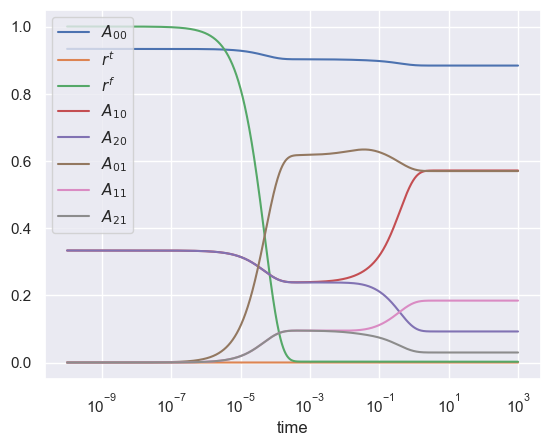

In [349]:
tend = 1000
t = np.geomspace(1e-10, tend, 10000)
z0 = [1/3, 1/3, 0, 0, 0]
t_span = [1e-10, tend]

z = solve_ivp(model_v2, t_span, z0, method='Radau', t_eval=t)

A00_vals = 1 - (1/beta_t)*(z.y[0] + z.y[1] + z.y[3] + z.y[4]) - (1/beta_f)*z.y[2]
rt_vals = 1- z.y[0] - z.y[3] - 2*(z.y[1] + z.y[4])
rf_vals = 1 - z.y[2] - phi*(z.y[3] + z.y[4])

sns.set_theme()
plt.plot(t, A00_vals, label = r'$A_{00}$')
plt.plot(t, rt_vals, label = r'$r^t$')
plt.plot(t, rf_vals, label = r'$r^f$')
plt.plot(t, z.y[0], label = r'$A_{10}$')
plt.plot(t, z.y[1], label = r'$A_{20}$')
plt.plot(t, z.y[2], label = r'$A_{01}$')
plt.plot(t, z.y[3], label = r'$A_{11}$')
plt.plot(t, z.y[4], label = r'$A_{21}$')
plt.xlabel('time')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

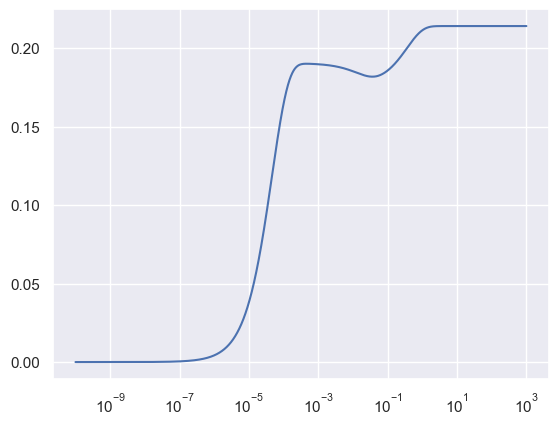

In [350]:
plt.plot(t, (z.y[3] + z.y[4])*1)
plt.xscale('log')
plt.show()